In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn

In [3]:
#Liraries used to save the model and results
import os
import joblib

In [4]:
#Import All the Regression Libraries
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor

In [5]:
#Import the  necessary evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
os.getcwd()

'/home/shrikrishna/Desktop/Edwisor/New Version/Project'

In [7]:
#Cross Validation
from sklearn.model_selection import KFold

## Load the imputed data

In [8]:
#Load the data free from Missing Values
absent = pd.read_csv('absent_NA_free.csv')

In [9]:
absent.head()

,Unnamed: 0,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,0,11,26.0,7.0,3,1,289.0,36.0,13.0,33.0,...,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,4.0
1,1,36,0.0,7.0,3,1,118.0,13.0,18.0,50.0,...,1.0,1.0,1.0,1.0,0.0,0.0,98.0,178.0,31.0,0.0
2,2,3,23.0,7.0,4,1,179.0,51.0,18.0,38.0,...,0.0,1.0,0.0,1.0,0.0,0.0,89.0,170.0,31.0,2.0
3,3,7,7.0,7.0,5,1,279.0,5.0,14.0,39.0,...,0.0,1.0,2.0,1.0,1.0,0.0,68.0,168.0,24.0,4.0
4,4,11,23.0,7.0,5,1,289.0,36.0,13.0,33.0,...,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,2.0


In [14]:
#Drop the redundant columns
#absent = absent.drop(["Unnamed: 0", "ID"], axis=1)

In [15]:
#Remove the trailing spaces if any from the columns names
absent.columns = list(map(lambda x: x.strip(" "), absent.columns))

In [16]:
#Check the types of each column
absent.dtypes

Reason for absence                 float64
Month of absence                   float64
Day of the week                      int64
Seasons                              int64
Transportation expense             float64
Distance from Residence to Work    float64
Service time                       float64
Age                                float64
Work load Average/day              float64
Hit target                         float64
Disciplinary failure               float64
Education                          float64
Son                                float64
Social drinker                     float64
Social smoker                      float64
Pet                                float64
Weight                             float64
Height                             float64
Body mass index                    float64
Absenteeism time in hours          float64
dtype: object

In [17]:
#Function to convert string to an integer
def string_to_int(query):
    #Process only if the value is not null
    if(type(query)==str):
        return int("".join(str(piece) for piece in query.split(',')))
    
    return query

In [18]:
temp_work_load_avg_per_d = absent["Work load Average/day"]

In [19]:
absent["Work load Average/day"] = list(map(string_to_int, np.array(temp_work_load_avg_per_d)))

In [20]:
#Check the whether any element of type Object exists in the column
#If no any element exists then this should return []
[ele for ele in list(absent["Work load Average/day"]) if type(ele)==str]

[]

In [21]:
#Assign the target column to variable target
target = "Absenteeism time in hours"

### Mapping Categories to Ordinal Data

In [92]:
social_drinker_dict = {"yes": 1, "no": 0}
education_dict = {"high school":1, "graduate":2,
                  "postgraduate":3, "master and doctor": 4
                 }
seasons_dict = {"summer":1, "autumn":2, "winter":3, "spring": 4}
day_of_week_dict = {"Monday":2, "Tuesday":3, "Wednesday":4, "Thursday":5,"Friday":6}
social_smoker_dict = {"yes":1, "no":0}
disciplinary_failure_dict = {"yes":1, "no":0}

## Plotting Utility

In [93]:
help(plt.hist)

Help on function hist in module matplotlib.pyplot:

hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, hold=None, data=None, **kwargs)
    Plot a histogram.
    
    Compute and draw the histogram of *x*. The return value is a
    tuple (*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*,
    [*patches0*, *patches1*,...]) if the input contains multiple
    data.
    
    Multiple data can be provided via *x* as a list of datasets
    of potentially different length ([*x0*, *x1*, ...]), or as
    a 2-D ndarray in which each column is a dataset.  Note that
    the ndarray form is transposed relative to the list form.
    
    Masked arrays are not supported at present.
    
    Parameters
    ----------
    x : (n,) array or sequence of (n,) arrays
        Input values, this takes either a single array or a sequence of


In [94]:
def plotting(data, x, y, file_name, t="scatter"):
    if(t=="hist"):
        plt.hist(data[y])
        plt.xlabel(y)
        plt.ylabel("Frequency Count")
        return plt
    elif(t=="line"):
        plt.plot(data[x], data[y])
    else:
        plt.scatter(data[x], data[y])
    plt.title(x + " V/S " + y)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.savefig(file_name)
    return plt

## Age V/S Absenteeism

In [25]:
#Obtain the count of distinct ages
from collections import Counter
count_age = Counter(np.array(absent["Age"]).ravel())

In [26]:
#Create a Data Frame
count_age = dict(count_age)
count_age = pd.DataFrame({"Age": list(count_age.keys()), "Frequency": list(count_age.values())}, columns = ["Age", "Frequency"])


In [27]:
count_age = count_age.sort_values(by="Frequency", ascending=False)
#count_age

In [28]:
#Create bins of Age Group
#Below 30, 30-40, 40-50, Above 50
below_30, betw_30_40 = absent[absent["Age"]<30], absent[(absent["Age"]>=30) & (absent["Age"]<40)]
betw_40_50, above_50 = absent[(absent["Age"]>=40) & (absent["Age"]<50)], absent[absent["Age"]>=50]

In [29]:
#Find the average hours of Absenteeism per Age group
def average(df, target = target):
    return (np.average(np.array(df[target])))

In [30]:
age_group_df_list = [below_30, betw_30_40, betw_40_50, above_50]
list(map(average, age_group_df_list))

[5.315384615384615, 6.8692493946731235, 6.311258278145695, 12.934782608695652]

## Observations

## Social Smoker, Social Drinkers V/S Absenteeism Hours

In [31]:
#Smokers and Drinkers
smoker_drinker = absent[(absent["Social drinker"]==1) & (absent["Social smoker"]==1)]

In [32]:
smoker_drinker.head()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
3,7.0,7.0,5,1,279.0,5.0,14.0,39.0,239554.0,97.0,0.0,1.0,2.0,1.0,1.0,0.0,68.0,168.0,24.0,4.0
27,28.0,8.0,4,1,157.0,27.0,6.0,29.0,205917.0,92.0,0.0,1.0,0.0,1.0,1.0,0.0,75.0,185.0,25.0,4.0
91,21.0,11.0,4,4,179.0,22.0,17.0,40.0,306345.0,95.0,0.0,2.0,2.0,1.0,1.0,0.0,63.0,170.0,22.0,8.0
157,19.0,3.0,3,2,157.0,27.0,6.0,29.0,343253.0,95.0,0.0,1.0,0.0,1.0,1.0,0.0,75.0,185.0,22.0,3.0
172,14.0,3.0,2,2,279.0,5.0,14.0,39.0,343253.0,95.0,0.0,1.0,2.0,1.0,1.0,0.0,68.0,168.0,24.0,8.0


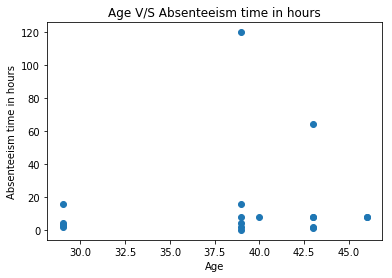

In [95]:
#Plot Age V/S target
plotting(smoker_drinker, "Age", target, "Smokers and Drinkers Versus Absenteeism Hours").show()


### Smokers or Drinkers

<module 'matplotlib.pyplot' from '/home/shrikrishna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

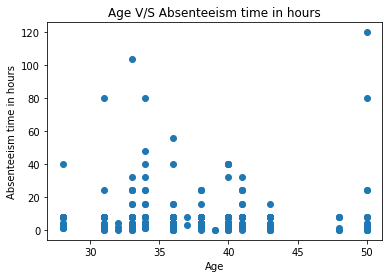

In [96]:
#Smokers or Drinkers
#These are the people who are either smokers or drinkers or both
smoker_OR_drinker = absent[((absent["Social drinker"]==0) & (absent["Social smoker"]==1)) | ((absent["Social drinker"]==1) & (absent["Social smoker"]==0))]
plotting(smoker_OR_drinker, "Age", target, "Smokers or Drinkers Versus Absenteeism Hours")


<module 'matplotlib.pyplot' from '/home/shrikrishna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

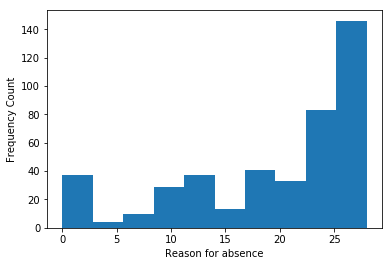

In [97]:
#Diseases to this group
plotting(smoker_OR_drinker, "", "Reason for absence", "Smokers or Drinkers Reason of Absence Count", "hist")

### Only Smokers

<module 'matplotlib.pyplot' from '/home/shrikrishna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

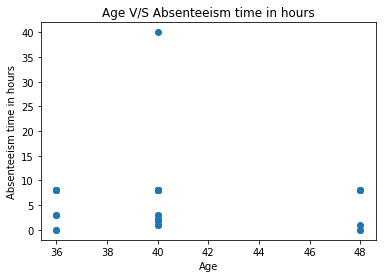

In [102]:
#Only Smokers
smoker = absent[(absent["Social drinker"]==0) & (absent["Social smoker"]==1)]
plotting(smoker, "Age",  target, "Smokers Versus Absnteeism Hours")

<module 'matplotlib.pyplot' from '/home/shrikrishna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

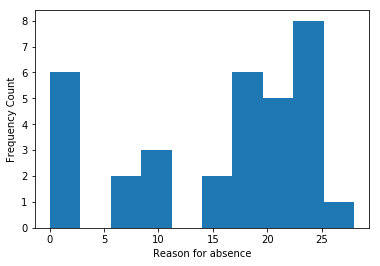

In [100]:
#Diseases to this group
plotting(smoker, "", "Reason for absence", "Smokers Versus Absnteeism Hours Frequency Count", "hist")

### Only Drinkers

<module 'matplotlib.pyplot' from '/home/shrikrishna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

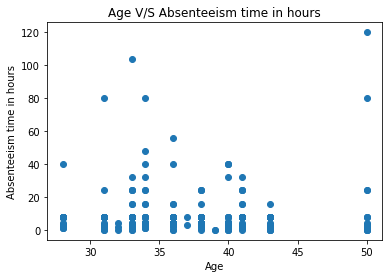

In [103]:
#Only Drinkers
drinker = absent[(absent["Social drinker"]==1) & (absent["Social smoker"]==0)]
plotting(drinker, "Age", target, "Drinkers Versus Absenteeism Hours")

<module 'matplotlib.pyplot' from '/home/shrikrishna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

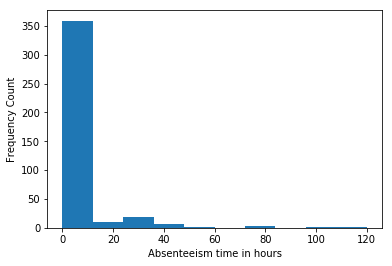

In [104]:
plotting(drinker, "Age", target, "Drinkers Versus Absnteeism Hours Frequency Count", "hist")

<module 'matplotlib.pyplot' from '/home/shrikrishna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

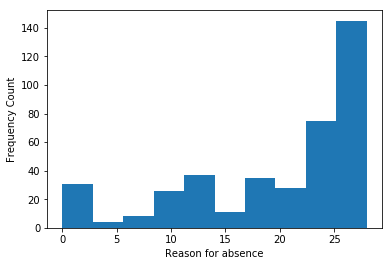

In [105]:
#Diseases to this group
plotting(drinker, "", "Reason for absence", "Reason for Absence for Drinkers", "hist")

In [110]:
Counter(drinker["Reason for absence"])

Counter({26.0: 25,
         0.0: 26,
         23.0: 67,
         22.0: 26,
         19.0: 26,
         1.0: 5,
         11.0: 10,
         14.0: 10,
         21.0: 2,
         13.0: 33,
         28.0: 82,
         18.0: 9,
         25.0: 5,
         24.0: 3,
         10.0: 14,
         6.0: 3,
         7.0: 4,
         12.0: 4,
         8.0: 1,
         9.0: 2,
         15.0: 1,
         4.0: 1,
         3.0: 1,
         27.0: 38,
         5.0: 2})

<module 'matplotlib.pyplot' from '/home/shrikrishna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

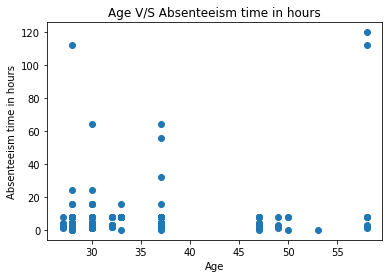

In [106]:
#Neither Smokers Nor Drinkers
non_addict = absent[(absent["Social drinker"]==0) & (absent["Social smoker"]==0)]
plotting(non_addict, "Age", target, "Absenteeism Hours for Non Addict")

<module 'matplotlib.pyplot' from '/home/shrikrishna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

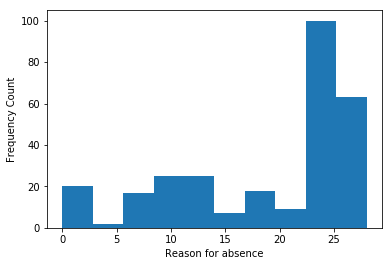

In [107]:
#Diseases to this group
plotting(non_addict, "", "Reason for absence", "Reason for absence for Non Addict", "hist")

### Observations

## Analyze the Absenteeism trend Due to Pregnancy

In [44]:
#Reason for Absence Category 15
absent_pregnancy = absent.loc[absent["Reason for absence"]==15, :]

In [45]:
absent_pregnancy

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
335,15.0,11.0,6,4,260.0,50.0,11.0,36.0,284031.0,97.0,0.0,1.0,4.0,1.0,0.0,0.0,65.0,168.0,23.0,8.0
468,15.0,7.0,2,1,300.0,26.0,13.0,43.0,230290.0,92.0,0.0,1.0,2.0,1.0,1.0,1.0,77.0,175.0,25.0,8.0


## Relationship Between Distance of work from Residence and Hours of Absenteeism. Transportation Expense V/S Absenteeism

<module 'matplotlib.pyplot' from '/home/shrikrishna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

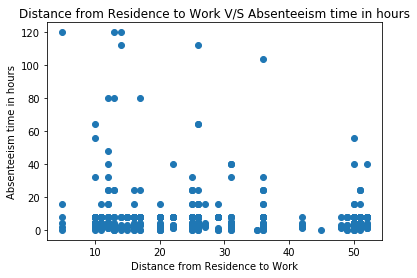

In [111]:
#Histogram
plotting(absent, "Distance from Residence to Work", target, "Distance from Residence to Work Versus Absenteism Hours")

In [112]:
dist_below_10 =absent[absent["Distance from Residence to Work"]<10]
dist_betw_10_20 = absent[(absent["Distance from Residence to Work"]>=10) & (absent["Distance from Residence to Work"]<20)]
dist_betw_20_40 = absent[(absent["Distance from Residence to Work"]>=20) & (absent["Distance from Residence to Work"]<40)]
dist_betw_40_50 = absent[(absent["Distance from Residence to Work"]>=40) & (absent["Distance from Residence to Work"]<50)]
above_50 = absent[absent["Distance from Residence to Work"]>=50]

In [113]:
#Average Absenteeism Hours distance from Residence to Work
dist_group_df_list = [dist_below_10, dist_betw_10_20, dist_betw_20_40, dist_betw_40_50, above_50]
list(map(average, dist_group_df_list))

[25.0,
 8.935643564356436,
 6.431677018633541,
 3.619047619047619,
 5.1534391534391535]

<module 'matplotlib.pyplot' from '/home/shrikrishna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

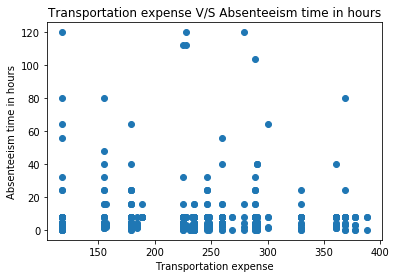

In [114]:
#Histogram
plotting(absent, "Transportation expense", target, "Transportation expense Versus Absenteeism Hours")

## Relationship Between Education and Hours of Absenteeism

<module 'matplotlib.pyplot' from '/home/shrikrishna/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

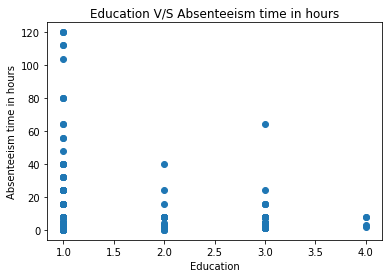

In [50]:
plotting(absent, "Education", target)

In [51]:
df_high_school, df_graduate = absent[absent["Education"]==1], absent[absent["Education"]==2]
df_PG, df_masters = absent[absent["Education"]==3], absent[absent["Education"]==4]

In [52]:
list(map(average, [df_high_school, df_graduate, df_PG, df_masters]))

[7.114566284779051, 6.282608695652174, 5.30379746835443, 5.25]

### Chi-Squared Test of Independence

In [53]:
categorical_variables = ["Reason for absence", "Social drinker", "Social smoker", "Seasons", "Day of the week", "Disciplinary failure", "Education"]

In [54]:
#Get the correlation between the categorical variables and perform the chi-squared test.
from scipy.stats import chi2_contingency
#category_dict = defaultdict()
print("Category_1\t\tCategory_2\t\tChi_Square\t\tP-Value")

select = []    #Include the variables whose p-value < 0.05

for cat_1 in categorical_variables:
        #category_dict[cat_1] = []
        for cat_2 in categorical_variables:
            #res = get_correlation_coefficient(absent[cat_1].tolist(), absent[cat_2].tolist())
            #category_dict[cat_1].append(res)
            if(cat_1!=cat_2):
                chi_value, p_value, dof, ex = chi2_contingency(
                                          pd.crosstab(absent[cat_1], absent[cat_2]))
                                          #Develop a Contingency table
                if(p_value<0.05):
                    if(cat_2 not in select):
                        select.append(cat_2)
                print("%s\t%s\t\t%.4f\t\t%.4f" %(cat_1,cat_2,chi_value, p_value))

Category_1		Category_2		Chi_Square		P-Value
Reason for absence	Social drinker		86.5335		0.0000
Reason for absence	Social smoker		93.8297		0.0000
Reason for absence	Seasons		267.9354		0.0000
Reason for absence	Day of the week		131.3106		0.0631
Reason for absence	Disciplinary failure		667.3330		0.0000
Reason for absence	Education		189.1442		0.0000
Social drinker	Reason for absence		86.5335		0.0000
Social drinker	Social smoker		6.9266		0.0085
Social drinker	Seasons		5.5355		0.1365
Social drinker	Day of the week		2.7203		0.6057
Social drinker	Disciplinary failure		1.2108		0.2712
Social drinker	Education		161.7074		0.0000
Social smoker	Reason for absence		93.8297		0.0000
Social smoker	Social drinker		6.9266		0.0085
Social smoker	Seasons		6.7584		0.0800
Social smoker	Day of the week		1.6061		0.8077
Social smoker	Disciplinary failure		8.6668		0.0032
Social smoker	Education		98.2601		0.0000
Seasons	Reason for absence		267.9354		0.0000
Seasons	Social drinker		5.5355		0.1365
Seasons	Social smoke

In [55]:
select

['Social drinker',
 'Social smoker',
 'Seasons',
 'Disciplinary failure',
 'Education',
 'Reason for absence']

In [56]:
#Consider the selected features from the categorical features and the non-categorical features
features = list(set(set(absent.columns) - set(categorical_variables)).union(set(select)))

#remove the target
features.remove('Absenteeism time in hours')

In [57]:
#Check the features not present in the features list
[col for col in absent.columns if col not in features]

['Day of the week', 'Absenteeism time in hours']

In [58]:
#Set the dependent and Independent Variables
target = "Absenteeism time in hours"
X = absent.loc[:, features]
y = absent[target]

(array([678.,  19.,  21.,   7.,   3.,   3.,   3.,   0.,   1.,   5.]),
 array([  0.,  12.,  24.,  36.,  48.,  60.,  72.,  84.,  96., 108., 120.]),
 <a list of 10 Patch objects>)

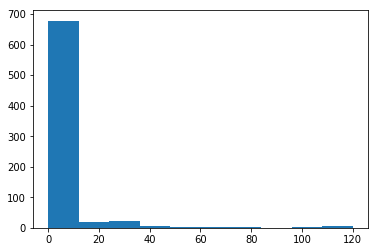

In [59]:
plt.hist(y)

In [60]:
#Split the data into training and testing set
from sklearn.model_selection import train_test_split
def split_data(X, y, manual = False):
    if(manual!=False):
        #Top 20 percent rows testing and rest training
        l = int(0.2* X.shape[0])
        X_test, y_test = (X.iloc[:l, :], y[:l])
        X_train, y_train = (X.iloc[l:, :], y[l:])
        #y_train, y_test = ()
        return (X_train, X_test, y_train, y_test)
    
    #Training Size - 80%, Testing Size - 20% 
    #Random State - set the seed of the random number generator
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    return(X_train, X_test, y_train, y_test)
    

In [61]:
X.shape

(740, 18)

## Split the data in a Definite Manner

## Split the data Randomly

In [62]:

X_train, X_test, y_train, y_test = split_data(X, y)
print("X_train:- {}\tX_test:- {}\ny_train:- {}\ty_test:- {}" .format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X_train:- (592, 18)	X_test:- (148, 18)
y_train:- (592,)	y_test:- (148,)


In [65]:
#Check the accuracy of various regressors
from sklearn.model_selection import cross_val_score
def check_cv(X, y, regressor):
    #Perform 7 fold(default=3) cross validation on training data
    scores = cross_val_score(estimator= regressor, X=X, y=y, cv=7, n_jobs=1)
    print("Scores:-{}\n" .format(scores))
    print("Average Accuracy:- %.2f\n" %(np.mean(scores)))

In [66]:
#Check the check_cv function
#Cross Validation is perfromed on Training Set and NOT on Test Set
lr = LinearRegression()

check_cv(X_train, y_train, lr)
#print("RMSE:- %.2f\tR-Squared:- %.2f" %(check_cv(X_train, y_train, lr)[0], check_cv(X_train, y_train, lr)[1]))

Scores:-[ 0.11224614 -0.00982443  0.09849869  0.06656508  0.01120429  0.1056465
 -0.12816056]

Average Accuracy:- 0.04



In [67]:
from sklearn.model_selection import cross_val_score

In [62]:
help(cross_val_score)

Help on function cross_val_score in module sklearn.model_selection._validation:

cross_val_score(estimator, X, y=None, groups=None, scoring=None, cv=None, n_jobs=1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
    Evaluate a score by cross-validation
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    
    X : array-like
        The data to fit. Can be for example a list, or an array.
    
    y : array-like, optional, default: None
        The target variable to try to predict in the case of
        supervised learning.
    
    groups : array-like, with shape (n_samples,), optional
        Group labels for the samples used while splitting the dataset into
        train/test set.
    
    scoring : string, callable or None, optional, default: None
        A string (see model evaluation documentation) or
        a scorer callable obje

## Note:-
Create directories named Ridge, Lasso, SVR, Random Forest and Simple Linear.
The models and their respective results will be stored in these folders.

In [78]:
class Regression():
    
    base_path = os.getcwd() + "/Models/"
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
    
    #Check the cross validation accuracies of various regressors
    def check_cv(self, regressor):
        #Perform 7 fold(default=3) cross validation on training data
        scores = cross_val_score(estimator= regressor, X=self.X_train, y=self.y_train, cv=7, n_jobs=1)
        print("Scores:-{}\n" .format(scores))
        print("Average Accuracy:- %.2f" %(np.mean(scores)))
    
    def save_model_results(self, actual, predicted, regressor, regressor_type, train_test):
        path = self.base_path + regressor_type 
        result_df = pd.DataFrame({"Actual":actual, "Predicted":predicted}, columns=["Actual", "Predicted"])
        result_df.to_csv(path + train_test + "_result.csv")
        joblib.dump(regressor, path + "/regression.pkl")
        
    def evaluate(self, actual, predicted):
        return(np.sqrt(mean_squared_error(actual, predicted)), r2_score(actual, predicted))
    
    def prediction_ridge(self):
        regressor = Ridge()
        regressor.fit(self.X_train, self.y_train)
        predicted_train = regressor.predict(self.X_train)
        predicted_test = regressor.predict(self.X_test)
        self.save_model_results(self.y_train.ravel(), predicted_train, regressor, "Ridge", "TRAIN")
        self.save_model_results(self.y_test.ravel(), predicted_test, regressor, "Ridge", "TEST")
        
        #Cross Validation Score
        print("Cross Validation Score Ridge:-\n")
        self.check_cv(regressor)
        
        #Training and Testing results are returned as a tuple
        result_train = self.evaluate(self.y_train, predicted_train)
        print("Train\nRMSE:-{}\tR-Squared:-{}\n" .format(result_train[0], result_train[1]))
        result_test = self.evaluate(self.y_test, predicted_test)
        print("Test\nRMSE:-{}\tR-Squared:-{}\n" .format(result_test[0], result_test[1]))
        
    def prediction_lasso(self):
        regressor = Lasso()
        regressor.fit(self.X_train, self.y_train)
        predicted_train = regressor.predict(self.X_train)
        predicted_test = regressor.predict(self.X_test)
        self.save_model_results(self.y_train.ravel(), predicted_train, regressor, "Lasso", "TRAIN")
        self.save_model_results(self.y_test.ravel(), predicted_test, regressor, "Lasso", "TEST")
        
        
        #Cross Validation Score
        print("Cross Validation Score Lasso:-\n")
        self.check_cv(regressor)
        
        #Training and Testing results are returned as a tuple
        result_train = self.evaluate(self.y_train, predicted_train)
        print("Train\nRMSE:-{}\tR-Squared:-{}\n" .format(result_train[0], result_train[1]))
        result_test = self.evaluate(self.y_test, predicted_test)
        print("Test\nRMSE:-{}\tR-Squared:-{}\n" .format(result_test[0], result_test[1]))

    
    def prediction_SVR(self):
        regressor = SVR()
        regressor.fit(self.X_train, self.y_train)
        predicted_train = regressor.predict(self.X_train)
        predicted_test = regressor.predict(self.X_test)
        self.save_model_results(self.y_train.ravel(), predicted_train, regressor, "SVR", "TRAIN")
        self.save_model_results(self.y_test.ravel(), predicted_test, regressor, "SVR", "TEST")
        
        
        #Cross Validation Score
        print("Cross Validation Score Support Vector Regressor:-\n")
        self.check_cv(regressor)
        
        #Training and Testing results are returned as a tuple
        result_train = self.evaluate(self.y_train, predicted_train)
        print("Train\nRMSE:-{}\tR-Squared:-{}\n" .format(result_train[0], result_train[1]))
        result_test = self.evaluate(self.y_test, predicted_test)
        print("Test\nRMSE:-{}\tR-Squared:-{}\n" .format(result_test[0], result_test[1]))
    
    def prediction_linear(self):
        regressor = LinearRegression()
        regressor.fit(self.X_train, self.y_train)
        predicted_train = regressor.predict(self.X_train)
        predicted_test = regressor.predict(self.X_test)
        self.save_model_results(self.y_train.ravel(), predicted_train, regressor, "Simple Linear", "TRAIN")
        self.save_model_results(self.y_test.ravel(), predicted_test, regressor, "Simple Linear", "TEST")
        
        
        #Cross Validation Score
        print("Cross Validation Score Simple Linear Regressor:-\n")
        self.check_cv(regressor)
        
        #Training and Testing results are returned as a tuple
        result_train = self.evaluate(self.y_train, predicted_train)
        print("Train\nRMSE:-{}\tR-Squared:-{}\n" .format(result_train[0], result_train[1]))
        result_test = self.evaluate(self.y_test, predicted_test)
        print("Test\nRMSE:-{}\tR-Squared:-{}\n" .format(result_test[0], result_test[1]))
    
    def prediction_random_forest(self, n_tree=100):
        
        #Create a regressor Object with default 100 trees/ 
        regressor = RFR(n_estimators=n_tree)
        regressor.fit(self.X_train, self.y_train)     
        predicted_train = regressor.predict(self.X_train)
        predicted_test = regressor.predict(self.X_test)
        self.save_model_results(self.y_train.ravel(), predicted_train, regressor, "Random Forest", "TRAIN")
        self.save_model_results(self.y_test.ravel(), predicted_test, regressor, "Random Forest", "TEST")
        
        
        #Cross Validation Score
        print("Cross Validation Score Random Forest Regressor:-\n")
        self.check_cv(regressor)
        
        #Training and Testing results are returned as a tuple
        result_train = self.evaluate(self.y_train, predicted_train)
        print("Train\nRMSE:-{}\tR-Squared:-{}\n" .format(result_train[0], result_train[1]))
        result_test = self.evaluate(self.y_test, predicted_test)
        print("Test\nRMSE:-{}\tR-Squared:-{}\n" .format(result_test[0], result_test[1]))

# Results for Definitely Split Data

In [79]:
#Pass an argument "True" to the function
X_train_def, X_test_def, y_train_def, y_test_def = split_data(X, y, True)
print("X_train:- {}\tX_test:- {}\ny_train:- {}\ty_test:- {}" .format(X_train_def.shape, X_test_def.shape, y_train_def.shape, y_test_def.shape))

X_train:- (592, 18)	X_test:- (148, 18)
y_train:- (592,)	y_test:- (148,)


## Ridge Regression

In [80]:
#Create a regression object
reg_def = Regression(X_train_def, X_test_def, y_train_def, y_test_def)


In [81]:
reg_def.prediction_ridge()

Cross Validation Score Ridge:-

Scores:-[ 0.06996076 -0.24301398 -0.11344871  0.02974605 -0.13200626  0.1164474
  0.10332875]

Average Accuracy:- -0.02
Train
RMSE:-13.214749063230181	R-Squared:-0.12135013250140336

Test
RMSE:-9.330285541108912	R-Squared:--0.010141922706112583



## Lasso Regression

In [82]:
reg_def.prediction_lasso()

Cross Validation Score Lasso:-

Scores:-[-0.11852122 -0.1574298   0.07153279  0.00096503 -0.12317795  0.07400131
  0.04889165]

Average Accuracy:- -0.03
Train
RMSE:-13.638699159168123	R-Squared:-0.0640688404683093

Test
RMSE:-9.18063565638492	R-Squared:-0.022001857086256238



## SVR

In [83]:
reg_def.prediction_SVR()

Cross Validation Score Support Vector Regressor:-

Scores:-[-0.19820194 -0.09383207 -0.0332653  -0.05120589 -0.04027834 -0.02292629
 -0.06894541]

Average Accuracy:- -0.07
Train
RMSE:-14.094305801769917	R-Squared:-0.0004940433060997007

Test
RMSE:-9.545851370363913	R-Squared:--0.05735752819013351



## Linear

In [84]:
reg_def.prediction_linear()

Cross Validation Score Simple Linear Regressor:-

Scores:-[ 0.07452169 -0.23583081 -0.12598486  0.03069765 -0.13605217  0.11688003
  0.10286464]

Average Accuracy:- -0.02
Train
RMSE:-13.214156603512933	R-Squared:-0.12142891613630591

Test
RMSE:-9.332959982952502	R-Squared:--0.0107211017684965



## Random Forest Regressor

In [85]:
#200 trees for Random Forest
reg_def.prediction_random_forest(200)

Cross Validation Score Random Forest Regressor:-

Scores:-[-0.5774654  -0.36617005 -0.37934922 -0.1340664  -0.3908796   0.09133712
 -0.10322218]

Average Accuracy:- -0.27
Train
RMSE:-6.996608716937653	R-Squared:-0.7536950271935778

Test
RMSE:-11.802825564578294	R-Squared:--0.6164582902643647



# Results for Randomly Split Data

## Ridge Regression

In [86]:
#Create a regression object
reg = Regression(X_train, X_test, y_train, y_test)


In [87]:
reg.prediction_ridge()

Cross Validation Score Ridge:-

Scores:-[ 0.11010545 -0.0071523   0.09740729  0.06763995  0.00620251  0.10280799
 -0.11539057]

Average Accuracy:- 0.04
Train
RMSE:-13.095629417871375	R-Squared:-0.11271689147569974

Test
RMSE:-9.88416026599644	R-Squared:-0.09993499363582425



## Lasso Regression

In [88]:
reg.prediction_lasso()

Cross Validation Score Lasso:-

Scores:-[ 0.06797426 -0.0268233   0.06744121  0.0528175  -0.12672776  0.04750403
  0.01056757]

Average Accuracy:- 0.01
Train
RMSE:-13.427419337747365	R-Squared:-0.0671870549160738

Test
RMSE:-10.502111765996455	R-Squared:--0.016126064490930903



## SVR

In [89]:
reg.prediction_SVR()

Cross Validation Score Support Vector Regressor:-

Scores:-[-0.03606462 -0.05236169 -0.07413423 -0.04118044 -0.07068727 -0.05606803
 -0.06531728]

Average Accuracy:- -0.06
Train
RMSE:-13.912408913204592	R-Squared:--0.0014150823149519098

Test
RMSE:-10.650135464198485	R-Squared:--0.04497183102086577



## Linear

In [90]:
reg.prediction_linear()

Cross Validation Score Simple Linear Regressor:-

Scores:-[ 0.11224614 -0.00982443  0.09849869  0.06656508  0.01120429  0.1056465
 -0.12816056]

Average Accuracy:- 0.04
Train
RMSE:-13.095021129524904	R-Squared:-0.11279931766885176

Test
RMSE:-9.874071889429075	R-Squared:-0.1017713784322899



## Random Forest Regressor

In [91]:
#Default 100 trees
reg.prediction_random_forest(200)

Cross Validation Score Random Forest Regressor:-

Scores:-[-0.16919994  0.10781022  0.26515943  0.15840907 -0.26435626  0.02663881
 -0.38577949]

Average Accuracy:- -0.04
Train
RMSE:-6.115096834467463	R-Squared:-0.8065288837614482

Test
RMSE:-12.653194881871293	R-Squared:--0.4750091481264169



In [84]:
help(KFold)

Help on class KFold in module sklearn.model_selection._split:

class KFold(_BaseKFold)
 |  K-Folds cross-validator
 |  
 |  Provides train/test indices to split data in train/test sets. Split
 |  dataset into k consecutive folds (without shuffling by default).
 |  
 |  Each fold is then used once as a validation while the k - 1 remaining
 |  folds form the training set.
 |  
 |  Read more in the :ref:`User Guide <cross_validation>`.
 |  
 |  Parameters
 |  ----------
 |  n_splits : int, default=3
 |      Number of folds. Must be at least 2.
 |  
 |  shuffle : boolean, optional
 |      Whether to shuffle the data before splitting into batches.
 |  
 |  random_state : int, RandomState instance or None, optional, default=None
 |      If int, random_state is the seed used by the random number generator;
 |      If RandomState instance, random_state is the random number generator;
 |      If None, the random number generator is the RandomState instance used
 |      by `np.random`. Used when

In [72]:
from sklearn.model_selection import KFold
class RandomForest():
    
    base_path = os.getcwd()
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
    
    def save_results(self, actual, predicted, path):
        #Create a data frame
        result_df = pd.DataFrame({"Actual": actual, "Predicted": predicted}, columns=["Actual", "Predicted"])
        
        #Write the result to a file
        result_df.to_csv(path)
    
    def kfold_cv(self, model, k=10):
        
        #K-Fold validation is performed on training data
        kf = KFold(n_splits=k)
        scores = []
        for train_index, test_index in kf.split(self.X_train):
            X_train, X_test = self.X_train.iloc[train_index, :], self.X_test.iloc[test_index, :]
            y_train, y_test = self.y_train[train_index], self.y_test[test_index]
            
            print("Train Index:-" + str(train_index))
            print("Test Index:-" + str(test_index))
            '''
            #Fit the model on training set
            rfr_model = model.fit(X_train, y_train)
            
            #Evaluate on validation set
            y_pred = rfr_model.predict()
            score = rfr_model.score(y_pred, y_test)
            scores.append(score)
        
        #Return the mean accuracy of all the folds
        return sum(scores)/len(scores)
        '''
    def evaluate(self, actual, predicted, train_test):
               
        path = self.base_path + train_test + "_random_forest.csv"
        self.save_results(actual, predicted, path)
        
        return (np.sqrt(mean_squared_error(actual, predicted)), r2_score(actual, predicted))
    
    def prediction(self, n_tree=100):
        
        #Create a regressor Object with default 100 trees/ 
        forest = RFR(n_estimators=n_tree)
        self.kfold_cv(forest)
        
        #Fit the model on the training data and save the model
        rfr_model = forest.fit(self.X_train, self.y_train)
        joblib.dump(rfr_model, self.base_path + "Randomforest.pkl")
        
        #Predict and Evaluate on the training set
        pred_train = rfr_model.predict(self.X_train)
        result = self.evaluate(self.y_train.ravel(), pred_train, "TRAIN")
        print("Train\nRMSE:- %.2f\tR-Squared:- %.2f\n" %(result[0], result[1]))
        
        #Predict and Evaluate on the testing set
        pred_test = rfr_model.predict(self.X_test)
        result = self.evaluate(self.y_test.ravel(), pred_test, "TEST")
        print("Test\nRMSE:- %.2f\tR-Squared:- %.2f\n" %(result[0], result[1]))
        
        #Predict and Evaluate on the Validation set
        #pred_val = rfr_model.predict(X_val)
        #result = self.evaluate(y_val.ravel(), pred_val)
        #print("Train\nRMSE:- %.2f\tR-Squared:- %.2f\n" %(result[0], result[1]))

In [ ]:
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None)
# X is the feature set and y is the target
for train_index, test_index in rkf.split(X):
    print("Train:", train_index, "Validation:", val_index)
    X_train, X_test = X[train_index], X[val_index]
    y_train, y_test = y[train_index], y[val_index]

In [47]:
#K-Fold Cross Validation
from sklearn.model_selection import KFold

kfold = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None)

NameError: name 'RepeatedKFold' is not defined

In [73]:
#Create an object of Random Forest class
rf = RandomForest(X_train, X_test, y_train, y_test)

In [74]:
#Predict on test train and validation sets with default 100 trees
rf.prediction(500)

Train Index:-[ 52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285
 286 287 288 289 290 291 292 293 294 2

/home/shrikrishna/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


IndexError: positional indexers are out-of-bounds